<h1 style="color:#1f77b4;">Age Progression & Regression with Conditional GAN (Scalar Age Input)</h1>

This project demonstrates how to use a Conditional GAN (CGAN) to generate synthetic human faces conditioned on **scalar age values**. It enables both **age progression** and **age regression** based on real-valued inputs like 5, 18, 30, etc.

---

<h2 style="color:#2ca02c;">Key Features</h2>

- Generates realistic 128x128 face images for any scalar age between 0 and 100
- Uses real-valued age as input condition (not one-hot encoded)
- Works with a small sample or can scale to the full dataset
- Easy to customize training parameters like epochs and batch size

---

<h2 style="color:#d62728;">Model Summary</h2>

- **Generator**: Accepts random noise and scalar age, outputs a face image
- **Discriminator**: Accepts image and scalar age, outputs real/fake score
- Implemented using TensorFlow/Keras

---

<h2 style="color:#9467bd;">Dataset</h2>

We use a **sample of the IMDB-WIKI dataset** for prototyping.

> You can **replace the sample subset with the full dataset** by increasing the `SAMPLE_SIZE` parameter in the code.

This allows the model to learn from a wider variety of faces and ages, improving generalization and output quality.

---

<h2 style="color:#8c564b;">Training Configuration</h2>

| Parameter     | Description                            | Default Value |
|---------------|----------------------------------------|----------------|
| `SAMPLE_SIZE` | Number of face images used             | `100`          |
| `EPOCHS`      | Number of training iterations          | `2`            |
| `BATCH_SIZE`  | Size of each training batch            | `16`           |
| `IMG_SIZE`    | Image dimensions                       | `128x128x3`    |

> You can **increase the `EPOCHS` value** (e.g., to 25 or 50) for better results.

---

<h2 style="color:#17becf;">Output</h2>

The generator creates synthetic face images for input ages like:

- Age 5  
- Age 18  
- Age 30  
- Age 75  

The output is based on a combination of noise and the target age value.

---

<h2 style="color:#bcbd22;">Model Files</h2>

The following models are saved after training:

- `cgan_generator_scalar_age.h5`
- `cgan_discriminator_scalar_age.h5`

These can be reused for generating new samples or for further training.

---

<h2 style="color:#ff7f0e;">Next Steps</h2>

- Train on the full IMDB-WIKI dataset
- Increase training epochs for better realism
- Experiment with other conditioning inputs (e.g., gender)
- Deploy the generator model in a simple web app for inference

---

<h2 style="color:#1f77b4;">Tip</h2>

To visualize **age progression**, generate faces using the same noise vector but different age inputs (e.g., 5, 15, 25, ..., 75). This shows how the face evolves with age.

---
---

In [1]:
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
#  Install dependencies

In [4]:
!pip install -q numpy pandas matplotlib scikit-learn opencv-python pillow kagglehub

In [5]:
#  Import libraries

In [6]:
import os

In [7]:
import numpy as np

In [8]:
import pandas as pd

In [9]:
import matplotlib.pyplot as plt

In [10]:
from PIL import Image

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
from tqdm import tqdm

In [13]:
import tensorflow as tf

In [14]:
from tensorflow.keras import layers, Model

In [15]:
from tensorflow.keras.models import load_model

In [16]:
import kagglehub

In [17]:
import gradio as gr

---
---

---
---

In [18]:
# Download dataset

In [19]:
path = kagglehub.dataset_download("abhikjha/imdb-wiki-faces-dataset")

100%|██████████| 5.92G/5.92G [00:45<00:00, 140MB/s]

Extracting files...


In [20]:
print("Dataset downloaded at:", path)

Dataset downloaded at: /root/.cache/kagglehub/datasets/abhikjha/imdb-wiki-faces-dataset/versions/2


---
---

---
---

In [21]:
# Constants

In [22]:
DATASET_DIR = os.path.join(path, "imdb_crop")

In [23]:
IMG_SIZE = (128, 128)

In [24]:
SAMPLE_SIZE = 100

In [25]:
LATENT_DIM = 100

---
---

---
---

In [26]:
#  Extract age from filename

In [27]:
def extract_age_from_filename(filename):
    try:
        parts = filename.split('_')
        birth_year = int(parts[2].split('-')[0])
        photo_year = int(parts[3].split('.')[0])
        return photo_year - birth_year
    except:
        return None

---
---

---
---

In [28]:
# Load image paths and ages

In [29]:
image_paths, ages = [], []

In [30]:
for root, _, files in os.walk(DATASET_DIR):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            age = extract_age_from_filename(file)
            if age is not None and 0 <= age <= 100:
                image_paths.append(os.path.join(root, file))
                ages.append(age)
        if len(image_paths) >= SAMPLE_SIZE:
            break
    if len(image_paths) >= SAMPLE_SIZE:
        break

In [31]:
# Visual inspection

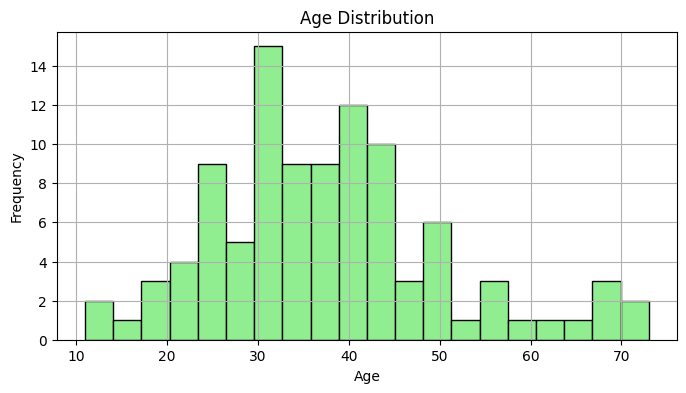

In [32]:
plt.figure(figsize=(8, 4))
plt.hist(ages, bins=20, color='lightgreen', edgecolor='black')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

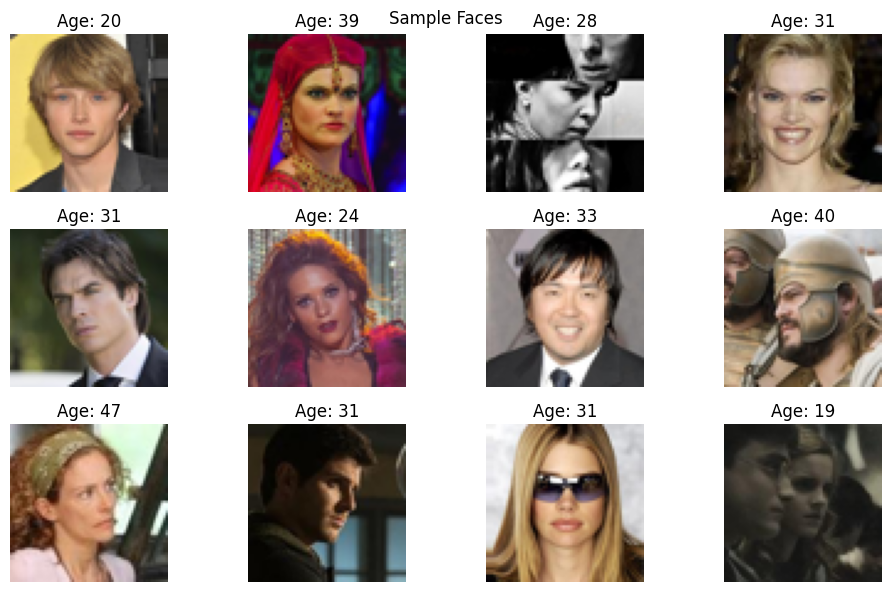

In [33]:
plt.figure(figsize=(10, 6))
for i in range(12):
    img = Image.open(image_paths[i]).convert("RGB").resize((64, 64))
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title(f"Age: {ages[i]}")
    plt.axis("off")
plt.tight_layout()
plt.suptitle("Sample Faces")
plt.show()

---
---

---
---

In [34]:
#  Load and preprocess images

In [35]:
images, age_scalars = [], []

In [36]:
for path, age in tqdm(zip(image_paths, ages), total=len(image_paths)):
    try:
        img = Image.open(path).convert("RGB").resize(IMG_SIZE)
        img = np.array(img, dtype=np.float32) / 255.0
        images.append(img)
        age_scalars.append(age / 100.0)  # Normalize age
    except:
        continue

100%|██████████| 100/100 [00:00<00:00, 291.58it/s]


In [37]:
images = np.array(images)

In [38]:
age_scalars = np.array(age_scalars).reshape(-1, 1)

In [39]:
print(" Processed images shape:", images.shape)

 Processed images shape: (100, 128, 128, 3)


---
---

---
---

In [40]:
# Train-test split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(images, age_scalars, test_size=0.2, random_state=42)


---
---

---
---

In [42]:
# Define Generator (Conditional on real scalar age)

In [43]:
def build_generator():
    noise = layers.Input(shape=(LATENT_DIM,))
    age_input = layers.Input(shape=(1,))
    merged = layers.Concatenate()([noise, age_input])

    x = layers.Dense(16 * 16 * 128, activation="relu")(merged)
    x = layers.Reshape((16, 16, 128))(x)
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(128, kernel_size=3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(64, kernel_size=3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(3, kernel_size=3, padding="same", activation="sigmoid")(x)

    return Model([noise, age_input], x, name="Generator")

In [44]:
# Define Discriminator

In [45]:
def build_discriminator():
    img = layers.Input(shape=(128, 128, 3))
    age_input = layers.Input(shape=(1,))
    age_dense = layers.Dense(128 * 128 * 1)(age_input)
    age_reshaped = layers.Reshape((128, 128, 1))(age_dense)

    merged = layers.Concatenate(axis=-1)([img, age_reshaped])
    x = layers.Conv2D(64, kernel_size=3, strides=2, padding="same")(merged)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1, activation="sigmoid")(x)

    return Model([img, age_input], x, name="Discriminator")

In [46]:
# Compile models

In [47]:
generator = build_generator()

In [48]:
discriminator = build_discriminator()

In [49]:
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [50]:
z = layers.Input(shape=(LATENT_DIM,))

In [51]:
age = layers.Input(shape=(1,))

In [52]:
generated_img = generator([z, age])

In [53]:
discriminator.trainable = False

In [54]:
validity = discriminator([generated_img, age])

In [55]:
cgan = Model([z, age], validity)

In [56]:
cgan.compile(optimizer='adam', loss='binary_crossentropy')

---
---

---
---

In [57]:
# Training loop

In [58]:
EPOCHS = 2

In [59]:
BATCH_SIZE = 16

In [60]:
HALF_BATCH = BATCH_SIZE // 2

In [61]:
real = np.ones((HALF_BATCH, 1))

In [62]:
fake = np.zeros((HALF_BATCH, 1))

In [63]:
for epoch in range(EPOCHS):
    for _ in range(len(X_train) // HALF_BATCH):
        idx = np.random.randint(0, X_train.shape[0], HALF_BATCH)
        real_imgs = X_train[idx]
        real_ages = y_train[idx]

        noise = np.random.normal(0, 1, (HALF_BATCH, LATENT_DIM))
        sampled_ages = np.random.uniform(0, 1, (HALF_BATCH, 1))
        gen_imgs = generator.predict([noise, sampled_ages], verbose=0)

        d_loss_real = discriminator.train_on_batch([real_imgs, real_ages], real)
        d_loss_fake = discriminator.train_on_batch([gen_imgs, sampled_ages], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
        sampled_ages = np.random.uniform(0, 1, (BATCH_SIZE, 1))
        g_loss = cgan.train_on_batch([noise, sampled_ages], np.ones((BATCH_SIZE, 1)))

    print(f"Epoch {epoch+1}/{EPOCHS} — D loss: {d_loss[0]:.4f}, acc: {100*d_loss[1]:.2f}% — G loss: {g_loss:.4f}")

Epoch 1/2 — D loss: 0.7151, acc: 51.32% — G loss: 0.3939
Epoch 2/2 — D loss: 0.7382, acc: 50.32% — G loss: 0.2910


---
---

---
---

In [64]:
# Generate and display faces for specific ages

In [65]:
def generate_faces_by_age(generator, ages):
    noise = np.random.normal(0, 1, (len(ages), LATENT_DIM))
    normalized_ages = np.array(ages) / 100.0
    gen_imgs = generator.predict([noise, normalized_ages.reshape(-1, 1)], verbose=0)

    plt.figure(figsize=(15, 3))
    for i, img in enumerate(gen_imgs):
        plt.subplot(1, len(ages), i+1)
        plt.imshow(img)
        plt.title(f"Age {ages[i]}")
        plt.axis("off")
    plt.suptitle("Generated Faces for Given Ages")
    plt.show()

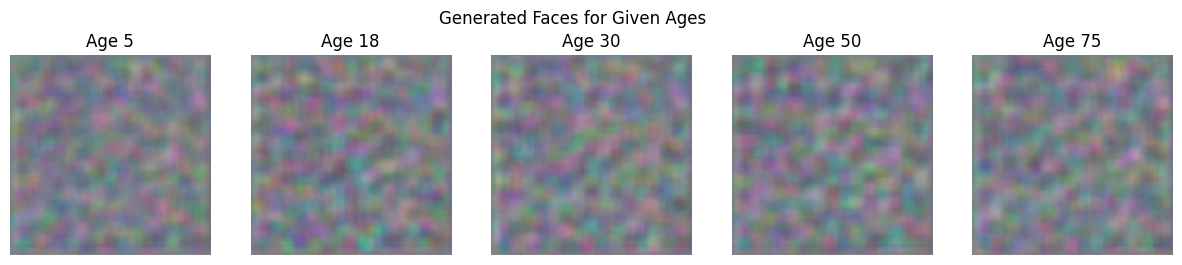

In [66]:
generate_faces_by_age(generator, [5, 18, 30, 50, 75])

---
---

---
---

In [67]:
# Save models

In [68]:
generator.save("cgan_generator_scalar_age.h5")

In [69]:
discriminator.save("cgan_discriminator_scalar_age.h5")

In [70]:
print(" Models saved: 'cgan_generator_scalar_age.h5', 'cgan_discriminator_scalar_age.h5'")


 Models saved: 'cgan_generator_scalar_age.h5', 'cgan_discriminator_scalar_age.h5'


---
---

---
---

#DEPLOYMENT METHOD: GRADIO INTERFACE

In [71]:
# Load saved models

In [72]:
generator = load_model("cgan_generator_scalar_age.h5")

In [73]:
discriminator = load_model("cgan_discriminator_scalar_age.h5")

In [74]:
# Latent space dimension (same as used during training)

In [75]:
LATENT_DIM = 100

In [76]:
# Function to generate and display a face at a given age

In [77]:
def generate_face_at_age(generator, age):
    noise = np.random.normal(0, 1, (1, LATENT_DIM))
    norm_age = np.array([[age / 100.0]])  # normalize age to [0,1]
    generated_img = generator.predict([noise, norm_age], verbose=0)[0]
    plt.figure(figsize=(3, 3))
    plt.imshow(generated_img)
    plt.title(f"Generated Face at Age {age}")
    plt.axis("off")
    plt.show()

In [78]:
# Test generation at specific ages(CAN BE ADJUSTED)

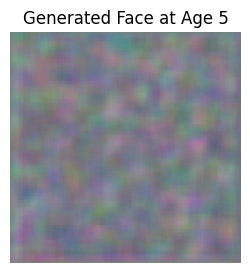

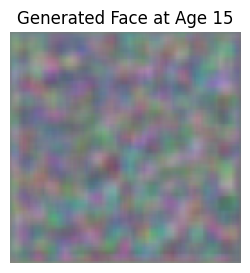

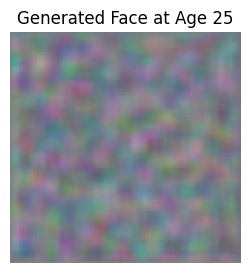

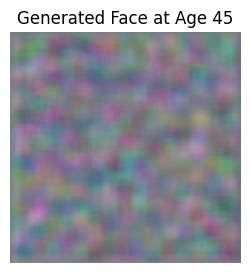

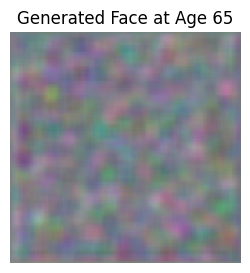

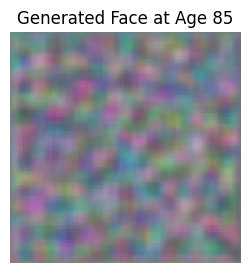

In [79]:
for age in [5, 15, 25, 45, 65, 85]:
    generate_face_at_age(generator, age)

In [80]:
# Gradio deployment

In [81]:
def predict_face(age):
    noise = np.random.normal(0, 1, (1, LATENT_DIM))
    norm_age = np.array([[age / 100.0]])
    generated_img = generator.predict([noise, norm_age], verbose=0)[0]
    return (generated_img * 255).astype("uint8")

In [82]:
iface = gr.Interface(
    fn=predict_face,
    inputs=gr.Slider(0, 100, label="Target Age"),
    outputs="image",
    title="Age Progression/Regression GAN",
    description="Generate synthetic faces at any age using a Conditional GAN."
)

In [83]:
iface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://99dfc402a71a2ede05.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


----
---